# Cognitive vs Cyclomatic Complexity

This notebook compares **Cognitive Complexity** and **Cyclomatic Complexity** for grading MBPP problem difficulty.

**Goal**: Choose the best metric to categorize problems as easy, medium, or hard for analyzing model performance patterns.

In [1]:
# Setup and imports
import ast
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from cognitive_complexity.api import get_cognitive_complexity
from radon.complexity import cc_visit

# Load MBPP dataset
dataset = load_dataset("Muennighoff/mbpp", "full")
print(f"Loaded {len(dataset['test'])} test problems")

/Users/krizroycetahimic/miniconda3/envs/pva_sae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 974 test problems


In [2]:
# Define complexity calculation functions
def get_cognitive(code):
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                return get_cognitive_complexity(node)
        return 0
    except:
        return None

def get_cyclomatic(code):
    try:
        results = cc_visit(code)
        return max(r.complexity for r in results) if results else 0
    except:
        return None

In [3]:
# Compare both metrics on sample problems
print("Comparing Complexity Metrics on MBPP Problems:\n")
print(f"{'Task':<6} {'Cognitive':<10} {'Cyclomatic':<11} Problem")
print("-" * 70)

for i in range(20):  # First 20 problems
    record = dataset['test'][i]
    cog = get_cognitive(record['code'])
    cyc = get_cyclomatic(record['code'])
    problem = record['text'][:40] + '...'
    print(f"{record['task_id']:<6} {cog:<10} {cyc:<11} {problem}")

Comparing Complexity Metrics on MBPP Problems:

Task   Cognitive  Cyclomatic  Problem
----------------------------------------------------------------------
1      5          7           Write a function to find the minimum cos...
2      0          1           Write a function to find the similar ele...
3      3          3           Write a python function to identify non-...
4      0          1           Write a function to find the largest int...
5      1          2           Write a function to find the number of w...
6      1          2           Write a python function to check whether...
7      0          1           Write a function to find all words which...
8      0          1           Write a function to find squares of indi...
9      3          3           Write a python function to find the mini...
10     0          1           Write a function to get the n smallest i...
11     6          5           Write a python function to remove first ...
12     0          1          

In [4]:
# Analyze all problems
cognitive_scores = []
cyclomatic_scores = []

for record in dataset['test']:
    cog = get_cognitive(record['code'])
    cyc = get_cyclomatic(record['code'])
    if cog is not None and cyc is not None:
        cognitive_scores.append(cog)
        cyclomatic_scores.append(cyc)

# Statistics
print("Distribution Analysis:")
print(f"\nCognitive Complexity:")
print(f"  Problems with score 0: {cognitive_scores.count(0)} ({cognitive_scores.count(0)/len(cognitive_scores)*100:.1f}%)")
print(f"  Mean: {np.mean(cognitive_scores):.2f}, Median: {np.median(cognitive_scores):.0f}")

print(f"\nCyclomatic Complexity:")
print(f"  Problems with score 1: {cyclomatic_scores.count(1)} ({cyclomatic_scores.count(1)/len(cyclomatic_scores)*100:.1f}%)")
print(f"  Mean: {np.mean(cyclomatic_scores):.2f}, Median: {np.median(cyclomatic_scores):.0f}")

Distribution Analysis:

Cognitive Complexity:
  Problems with score 0: 409 (42.0%)
  Mean: 2.30, Median: 1

Cyclomatic Complexity:
  Problems with score 1: 268 (27.5%)
  Mean: 2.84, Median: 2


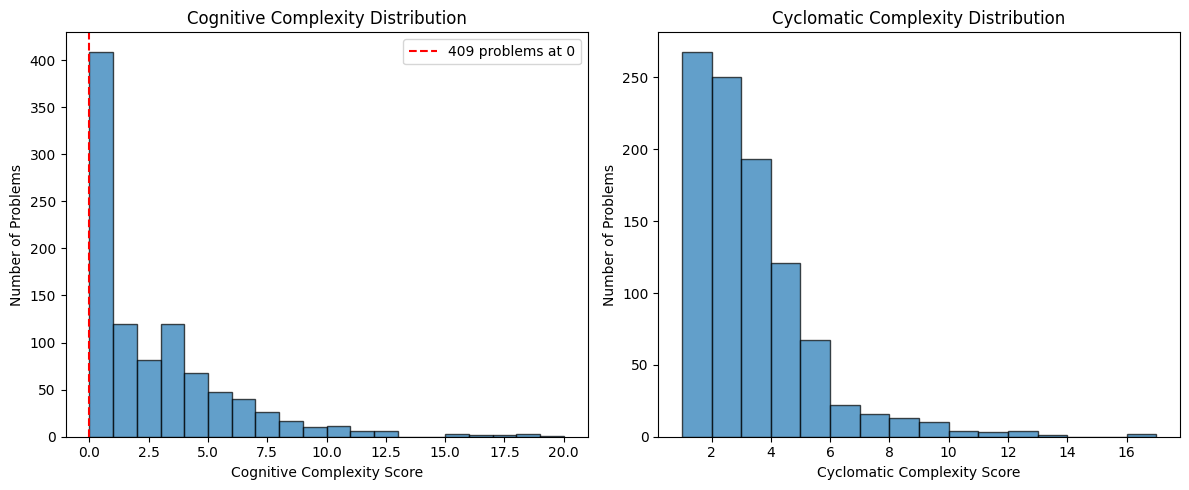

In [5]:
# Visualize distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Cognitive Complexity
ax1.hist(cognitive_scores, bins=range(0, max(cognitive_scores)+2), edgecolor='black', alpha=0.7)
ax1.set_xlabel('Cognitive Complexity Score')
ax1.set_ylabel('Number of Problems')
ax1.set_title('Cognitive Complexity Distribution')
ax1.axvline(x=0, color='red', linestyle='--', label=f'{cognitive_scores.count(0)} problems at 0')
ax1.legend()

# Cyclomatic Complexity  
ax2.hist(cyclomatic_scores, bins=range(1, max(cyclomatic_scores)+2), edgecolor='black', alpha=0.7)
ax2.set_xlabel('Cyclomatic Complexity Score')
ax2.set_ylabel('Number of Problems')
ax2.set_title('Cyclomatic Complexity Distribution')

plt.tight_layout()
plt.show()

## Key Finding

**Cognitive Complexity** gives a score of 0 to many MBPP problems because they lack control flow structures (if/for/while). This makes it poor for differentiating problem difficulty.

**Cyclomatic Complexity** provides better differentiation by counting all decision points, giving us a more nuanced difficulty grading.

### Recommended Difficulty Categories (Cyclomatic):
- **Easy**: 1-4 (simple, linear code)
- **Medium**: 5-7 (moderate complexity)
- **Hard**: 8+ (complex logic)

In [6]:
# Apply difficulty categories
def categorize(score):
    if score <= 4: return 'easy'
    elif score <= 7: return 'medium'
    else: return 'hard'

difficulties = [categorize(s) for s in cyclomatic_scores]
print("Problem Difficulty Distribution:")
for level in ['easy', 'medium', 'hard']:
    count = difficulties.count(level)
    print(f"  {level}: {count} ({count/len(difficulties)*100:.1f}%)")

Problem Difficulty Distribution:
  easy: 832 (85.4%)
  medium: 105 (10.8%)
  hard: 37 (3.8%)


In [1]:
# Test prompt builder with multiple examples
from common.prompt_utils import PromptBuilder
import numpy as np

print("=== Testing Prompt Builder with Multiple Examples ===\n")

for i in range(min(3, len(df))):  # Test first 3 problems
    sample = df.iloc[i]
    
    # Get test cases
    test_cases = sample.get('test_list', [])
    
    # Handle if test_cases is a numpy array or list
    if isinstance(test_cases, np.ndarray):
        test_cases = test_cases.tolist()
    
    if test_cases and len(test_cases) > 0:
        test_cases_str = '\n'.join(test_cases)
    else:
        test_cases_str = "# No test cases provided"
    
    # Build prompt
    prompt = PromptBuilder.build_prompt(
        problem_description=sample['text'],
        test_cases=test_cases_str
    )
    
    print(f"Example {i+1}:")
    print(f"Task ID: {sample['task_id']}")
    print(f"Problem: {sample['text'][:100]}..." if len(sample['text']) > 100 else sample['text'])
    print(f"\nPrompt Generated:")
    print("```")
    print(prompt)
    print("```")
    print("\n" + "="*70 + "\n")

ModuleNotFoundError: No module named 'common'